# Health Insurance Premium Regression: Exploratory Data Analysis and Hypothesis Testing

## Objective
This notebook aims to develop a machine learning model that predicts individual health insurance costs, enabling insurers to set premiums more accurately. By analyzing individual health data, this model will improve pricing precision, foster competitive advantage, and support personalized policy offerings, leading to better risk management and enhanced customer satisfaction.

In [1]:
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, shapiro, spearmanr
import math
from itertools import combinations
import statsmodels.api as sm

RED = "\033[31m"
GREEN = "\033[32m"
YELLOW = "\033[33m"
BLUE = "\033[34m"
RESET = "\033[0m"  # Resets to default color

sns.set_theme(style="darkgrid",palette="Pastel2")
%config InlineBackend.figure_format = 'svg'

## EDA

### Descriptive Analysis

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

Age  Diabetes  BloodPressureProblems  AnyTransplants  AnyChronicDiseases  \
0   45         0                      0               0                   0   
1   60         1                      0               0                   0   
2   36         1                      1               0                   0   
3   52         1                      1               0                   1   
4   38         0                      0               0                   1   

   Height  Weight  KnownAllergies  HistoryOfCancerInFamily  \
0     155      57               0                        0   
1     180      73               0                        0   
2     158      59               0                        0   
3     183      93               0                        0   
4     166      88               0                        0   

   NumberOfMajorSurgeries  PremiumPrice  
0                       0         25000  
1                       0         29000  
2                       1         23000  
3                       2         28000  
4                       1         23000

In [3]:
print('-'*80)
print(f'Shape of Data : {df.shape}')
print('-'*80)
print(f'Data Types : \n\n{df.dtypes}')
print('-'*80)
print(f'Count of Null values: \n\n{df.isnull().sum()}')
print('-'*80)
print(f'Count of duplicate rows: {df.duplicated().sum()}')
print('-'*80)
unique_values = {column: df[column].unique() for column in df.columns}
print(f'Unique Values : \n')
pprint.pprint(unique_values)
print('-'*80)


--------------------------------------------------------------------------------
Shape of Data : (986, 11)
--------------------------------------------------------------------------------
Data Types : 

Age                        int64
Diabetes                   int64
BloodPressureProblems      int64
AnyTransplants             int64
AnyChronicDiseases         int64
Height                     int64
Weight                     int64
KnownAllergies             int64
HistoryOfCancerInFamily    int64
NumberOfMajorSurgeries     int64
PremiumPrice               int64
dtype: object
--------------------------------------------------------------------------------
Count of Null values: 

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice             

In [4]:
# Converting categorical column to category type
cat_columns = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']
df[cat_columns] = df[cat_columns].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      986 non-null    int64   
 1   Diabetes                 986 non-null    category
 2   BloodPressureProblems    986 non-null    category
 3   AnyTransplants           986 non-null    category
 4   AnyChronicDiseases       986 non-null    category
 5   Height                   986 non-null    int64   
 6   Weight                   986 non-null    int64   
 7   KnownAllergies           986 non-null    category
 8   HistoryOfCancerInFamily  986 non-null    category
 9   NumberOfMajorSurgeries   986 non-null    int64   
 10  PremiumPrice             986 non-null    int64   
dtypes: category(6), int64(5)
memory usage: 45.1 KB


In [5]:
df.describe()

Age      Height      Weight  NumberOfMajorSurgeries  \
count  986.000000  986.000000  986.000000              986.000000   
mean    41.745436  168.182556   76.950304                0.667343   
std     13.963371   10.098155   14.265096                0.749205   
min     18.000000  145.000000   51.000000                0.000000   
25%     30.000000  161.000000   67.000000                0.000000   
50%     42.000000  168.000000   75.000000                1.000000   
75%     53.000000  176.000000   87.000000                1.000000   
max     66.000000  188.000000  132.000000                3.000000   

       PremiumPrice  
count    986.000000  
mean   24336.713996  
std     6248.184382  
min    15000.000000  
25%    21000.000000  
50%    23000.000000  
75%    28000.000000  
max    40000.000000

#### Insights

**1. Data Shape and Structure**

- Rows: 986
- Columns: 11, consisting of both predictor variables and a target variable (PremiumPrice).
- Target Variable: PremiumPrice (likely to be continuous since this is a regression problem).

**2. Data Types**

- All columns are currently of int64 type, which includes both categorical (binary and ordinal) and numerical features.
- Categorical variables like Diabetes, BloodPressureProblems, etc., are encoded as integers (0 and 1).
- It may be helpful to convert categorical features to a categorical data type if needed for certain modeling techniques.

**3. Missing and Duplicate Values**

- No Null Values: The dataset is complete, so no imputation or handling of missing data is necessary.
- No Duplicates: All rows are unique, which is beneficial as duplicate rows could bias the model.

**4. Unique Values per Feature**

- Age: Ranges from 18 to 66, indicating a middle-aged to senior demographic. This is typical for insurance-related datasets.
- Binary Categorical Columns: Diabetes, BloodPressureProblems, AnyTransplants, AnyChronicDiseases, HistoryOfCancerInFamily, and- - - KnownAllergies are binary (0 or 1), which makes them easy to interpret and model as dummy variables.
- Height and Weight: Distributed across a range of values, with Height from 145 to 188 cm and Weight from 51 to 132 kg. It maybe worth calculating BMI from these two features, as it might correlate better with PremiumPrice than using them separately.
- Number of Major Surgeries: Includes small values (0, 1, 2, 3), representing the number of surgeries, which might contributeto higher insurance premiums.
- PremiumPrice: Ranges from 15,000 to 40,000, showing variability, which is essential for training a regression model.

**5. Potential Feature Engineering**

- BMI: Adding BMI as a derived feature from Height and Weight could provide a more nuanced health-related feature.
- Age Groups: Consider creating age groups (e.g., 18–25, 26–35, etc.) to capture patterns across age ranges.
- Interaction Terms: You might explore interactions between health-related features (e.g., Diabetes and BloodPressureProblems), as combinations of conditions could impact premiums.

**6. Distribution of PremiumPrice**

- The range from 15,000 to 40,000 for PremiumPrice suggests a relatively wide distribution. Checking its distribution (e.g., histogram) could reveal skewness or outliers, which would influence the model’s performance and the choice of evaluation metrics.

In [6]:
# Creating the BMI column
df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)

In [7]:
# Creating Age group categorical variable
df['AgeGroup'] = pd.cut(df['Age'], bins=[17, 25, 35, 50, 70], labels=[1, 2, 3, 4])

In [8]:
numeric_columns = ['Age', 'Height', 'Weight', 'BMI',  'NumberOfMajorSurgeries']
categorical_columns = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily', 'AgeGroup']
target_column = 'PremiumPrice'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      986 non-null    int64   
 1   Diabetes                 986 non-null    category
 2   BloodPressureProblems    986 non-null    category
 3   AnyTransplants           986 non-null    category
 4   AnyChronicDiseases       986 non-null    category
 5   Height                   986 non-null    int64   
 6   Weight                   986 non-null    int64   
 7   KnownAllergies           986 non-null    category
 8   HistoryOfCancerInFamily  986 non-null    category
 9   NumberOfMajorSurgeries   986 non-null    int64   
 10  PremiumPrice             986 non-null    int64   
 11  BMI                      986 non-null    float64 
 12  AgeGroup                 986 non-null    category
dtypes: category(7), float64(1), int64(5)
memory usage: 54.0 KB


## Visual analysis

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_graphs(df, columns, target=None):
    rows = (len(columns) + 1) // 2
    cols = 2
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    index = 0
    
    for row in range(rows):
        for col in range(cols):
            if index >= len(columns):
                break
            col_name = columns[index]
            # Determine type based on dtype
            is_numeric = pd.api.types.is_numeric_dtype(df[col_name])
            
            if target is None:  # Univariate analysis
                if is_numeric:
                    sns.histplot(df[col_name], kde=True, ax=axs[row, col])
                else:
                    sns.countplot(x=col_name, data=df, ax=axs[row, col], alpha=0.8)
            else:  # Bivariate analysis
                if is_numeric:
                    sns.scatterplot(x=col_name, y=target, data=df, ax=axs[row, col])
                else:
                    sns.boxplot(x=col_name, y=target, data=df, ax=axs[row, col])
            index += 1
    
    # Hide the last empty plot if odd number of columns
    if len(columns) % 2 == 1:
        axs.flat[-1].set_visible(False)

    plt.tight_layout()
    plt.show()

#### Univariate Analysis

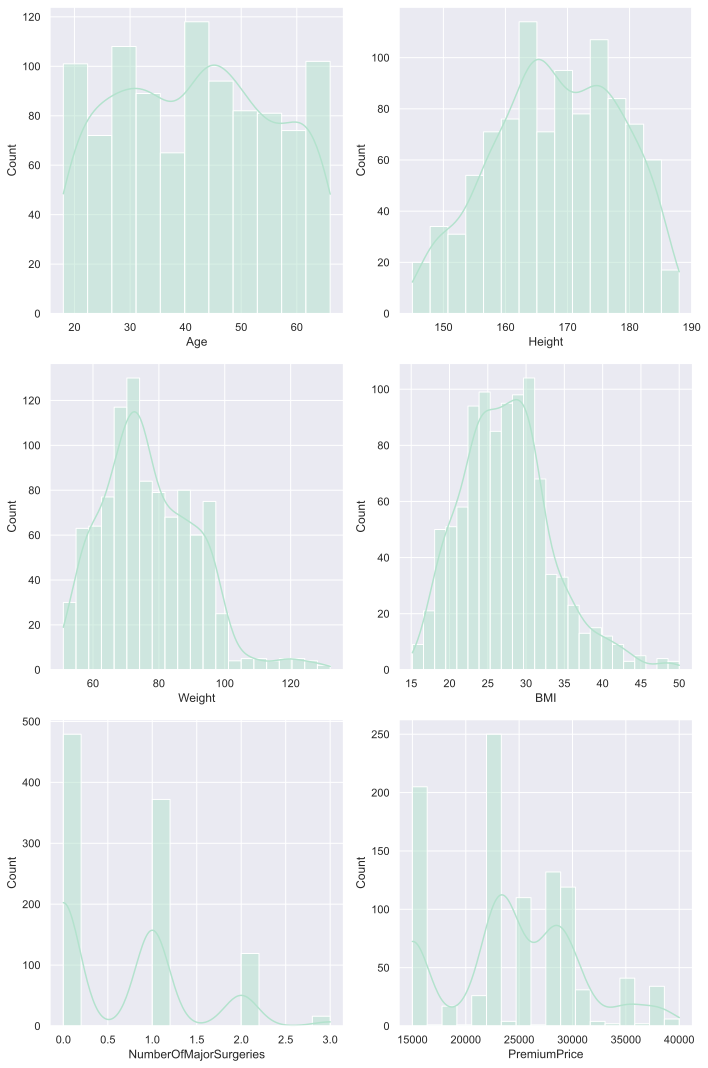

In [10]:
plot_graphs(df, numeric_columns + [target_column])

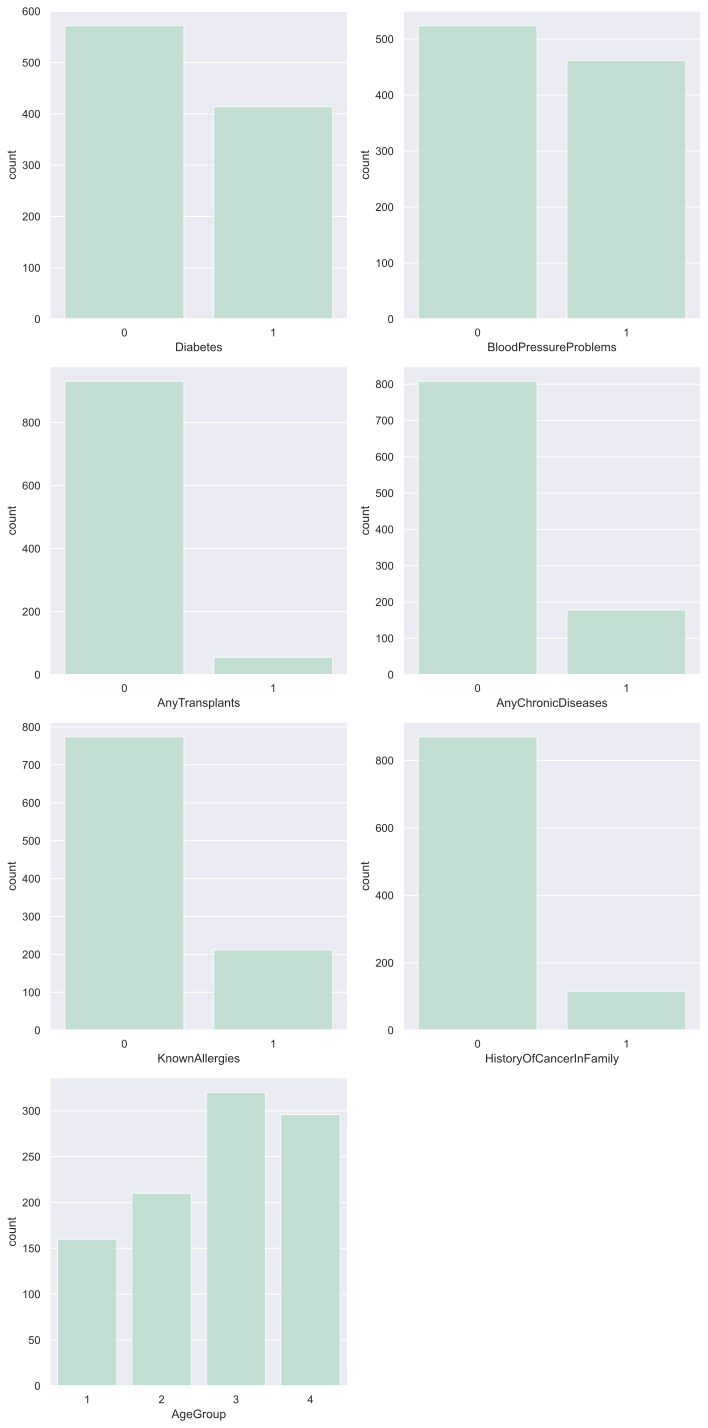

In [11]:
plot_graphs(df, categorical_columns)

#### Bivariate Analysis

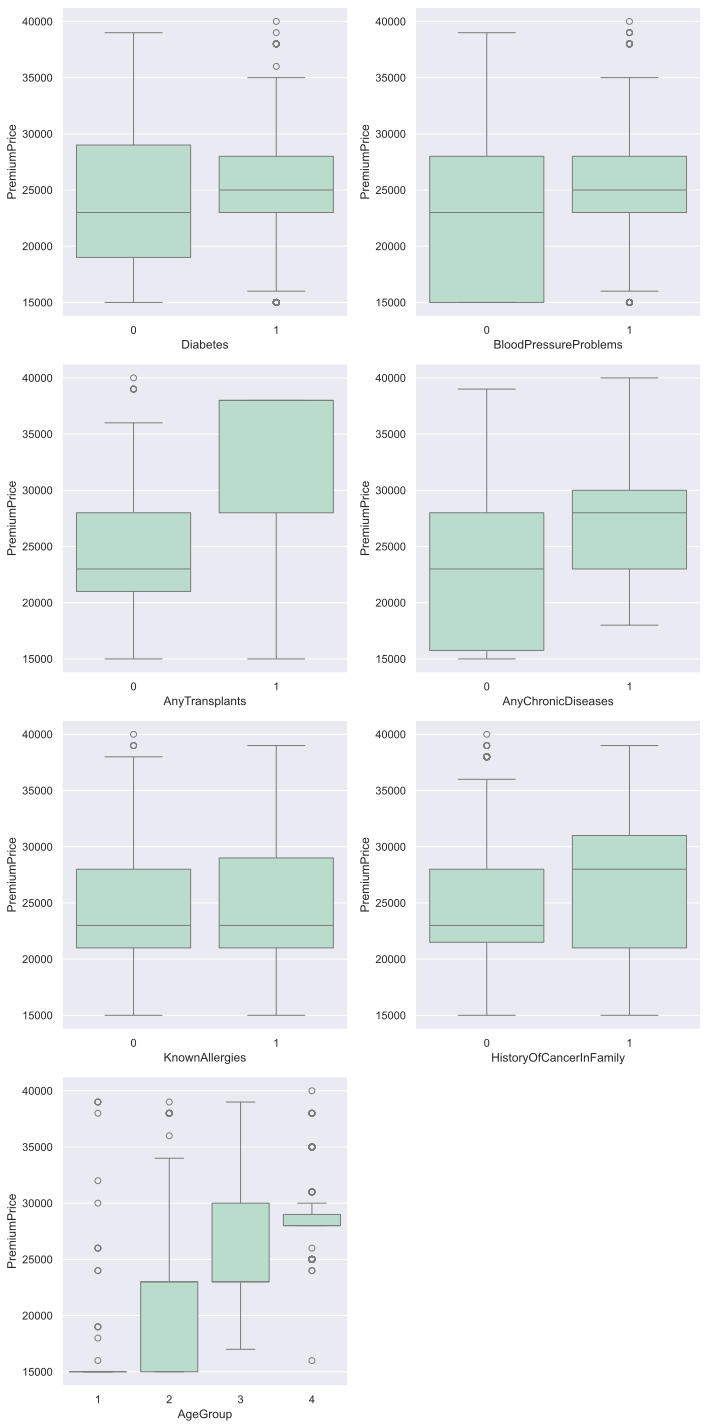

In [12]:
plot_graphs(df, categorical_columns, target_column)

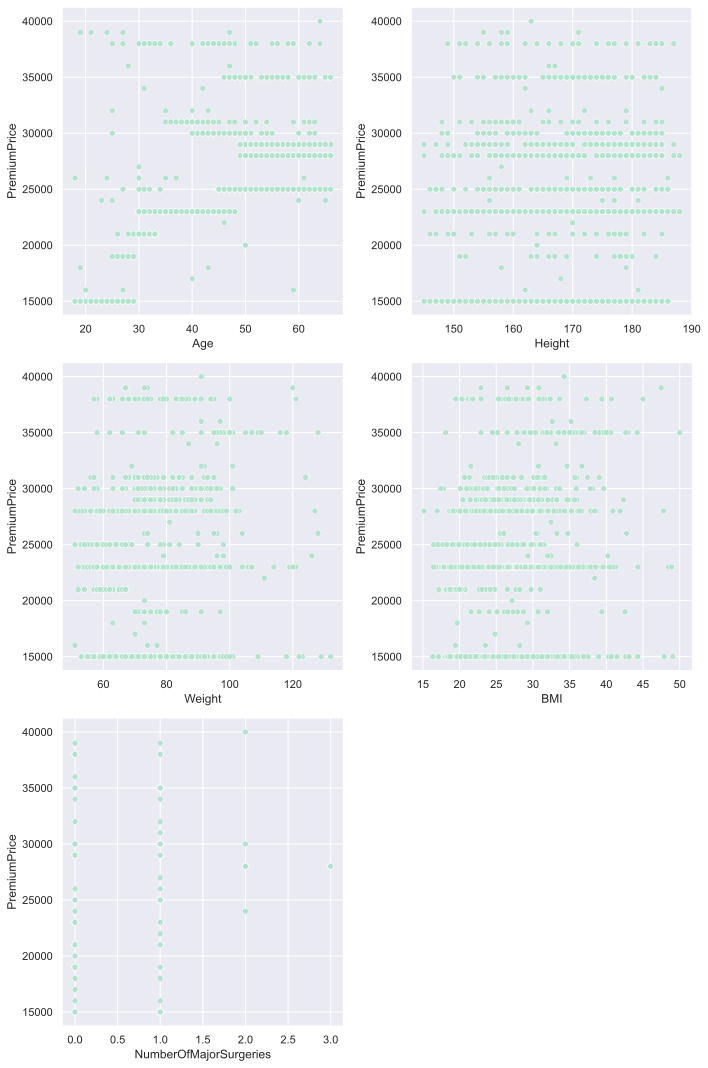

In [13]:
plot_graphs(df, numeric_columns, target_column)

#### Correlation Analysis

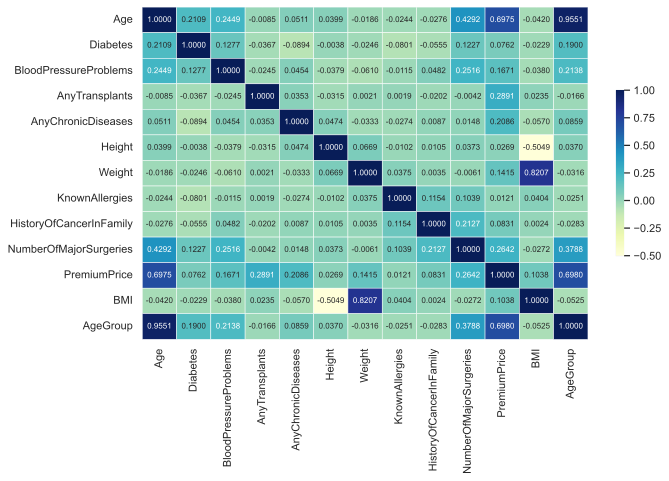

In [14]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt=".4f", annot_kws={"size": 8},  # Reduce font size
            square=False, cmap='YlGnBu', linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.show()

In [15]:
sns.pairplot(df[numeric_columns + [target_column]], kind='scatter', diag_kind='kde', height=1.9, plot_kws={'s': 15})
plt.show()

#### Insights

Based on the visual analysis of the data presented in the images, I can provide the following insights:

1.  Age Distribution:
    
    *   The age distribution appears to be centered around 40-50 years old, with the highest density between 30-60 years of age.
        
    *   There are some outliers at both the younger and older age ranges, but the majority of the data points are clustered in the middle-aged group.
        
2.  Health Conditions:
    
    *   The data covers several health conditions, including Diabetes, Blood Pressure Problems, Any Transplants, Any Chronic Diseases, and Known Allergies.
        
    *   For most of these conditions, the majority of data points are concentrated around 0, indicating a relatively low prevalence or severity of these conditions in the sample.
        
    *   The exception is Diabetes, which appears to have a higher concentration of data points compared to the other conditions.
        
3.  Biometric Factors:
    
    *   The data includes biometric factors such as Height, Weight, and BMI (Body Mass Index).
        
    *   The Height distribution appears to be centered around the 170-180 cm range, with a relatively symmetric spread.
        
    *   The Weight distribution shows a wider spread, with a concentration of data points in the 70-90 kg range.
        
    *   The BMI distribution is also centered around the 25-30 range, which is considered the overweight category.
        
4.  Family History and Surgeries:
    
    *   The data includes information on History of Cancer in the Family and Number of Major Surgeries.
        
    *   The History of Cancer in the Family variable shows a low prevalence, with most data points clustered around 0.
        
    *   The Number of Major Surgeries variable has a wider distribution, with a higher concentration of data points in the 1-2 range.
        
5.  Premium Price:
    
    *   The Premium Price variable appears to have a relatively wide distribution, with a concentration of data points in the $20,000-$30,000 range.
        
6.  Correlation Analysis:
    
    *   The Premium Price variable seems to have high correlation with Age, it is also shows heteroscedasticity

## Hypothesis Testing

In [16]:
def check_normality_multiple(df, numerical_columns, n_columns=2):
    shapiro_results = {}
    n_plots = len(numerical_columns)
    n_rows = math.ceil(n_plots / n_columns)
    
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(5 * n_columns, 5 * n_rows))
    axes = axes.flatten()  

    for i, column in enumerate(numerical_columns):
        stats.probplot(df[column], dist="norm", plot=axes[i])
        axes[i].set_title(f'QQ Plot for {column}')
        _, shapiro_p_value = shapiro(df[column])
        shapiro_results[column] = shapiro_p_value

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    print("\nShapiro-Wilk Test Results:")
    for column, p_value in shapiro_results.items():
        if p_value <= 0.05:
            print(f'{RED}{column}: Not normally distributed (p-value = {p_value:.3f}){RESET}')
        else:
            print(f'{GREEN}{column}: Normally distributed (p-value = {p_value:.3f}){RESET}')



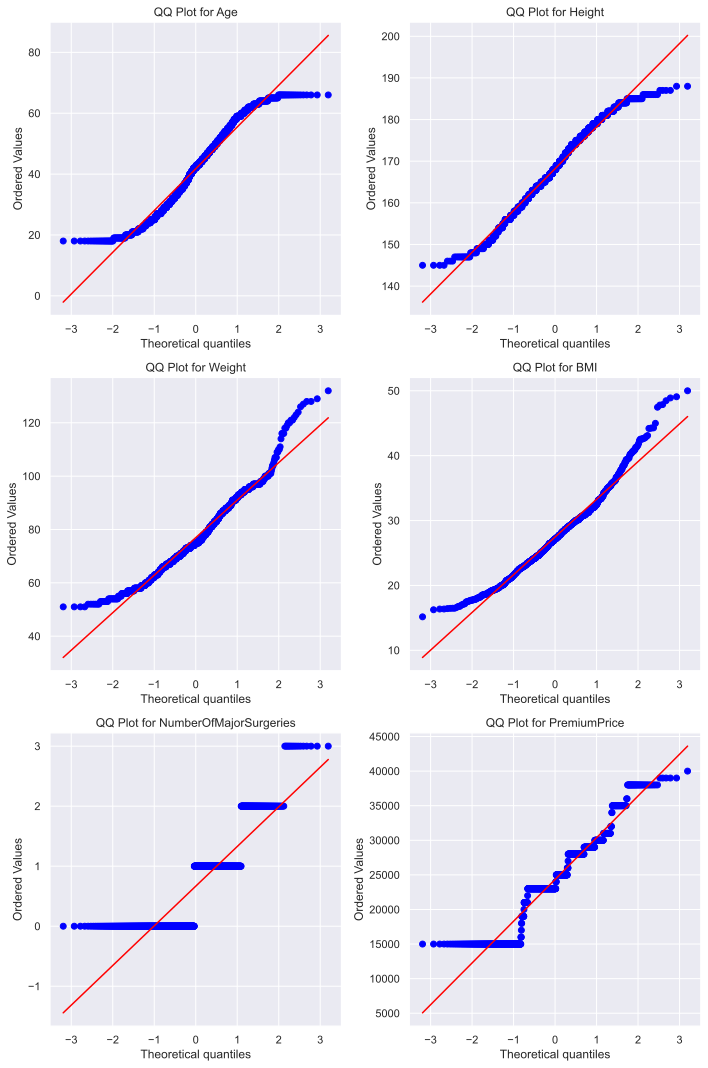


Shapiro-Wilk Test Results:
Age: Not normally distributed (p-value = 0.000)
Height: Not normally distributed (p-value = 0.000)
Weight: Not normally distributed (p-value = 0.000)
BMI: Not normally distributed (p-value = 0.000)
NumberOfMajorSurgeries: Not normally distributed (p-value = 0.000)
PremiumPrice: Not normally distributed (p-value = 0.000)


In [17]:
check_normality_multiple(df, numeric_columns+[target_column])

In [18]:
def t_test_ind(df, cat_cols, num_col):
    print('-' * 100)
    print('T-Test Independent Samples Results:')
    print(f"{'Categorical Variable':<25} {'Effect on PremiumPrice':<25} {'ttest_ind p-value':<25}")
    print("-" * 100)
    for cat_col in cat_cols:
        categories = df[cat_col].unique()
        data = [df[df[cat_col] == category][num_col] for category in categories]
        # Perform t-test
        t_statistic, p_value = ttest_ind(data[0], data[1])
        if p_value <= 0.05:
            result = "affects"
            print(f'{GREEN}{cat_col:<25} {result:<25} {p_value}{RESET}')
        else:
            result = "doesn't affect"
            print(f'{RED}{cat_col:<25} {result:<25} {p_value}{RESET}')

def anova(df, cat_cols, num_col):
    print('-' * 100)
    print('ANOVA Results:')
    print(f"{'Categorical Variable':<25} {'Effect on PremiumPrice':<25} {'anova p-value':<25}")
    print("-" * 100)
    for cat_col in cat_cols:
    # Perform ANOVA test between a categorical and a numerical column
        categories = df[cat_col].unique()
        data = [df[df[cat_col] == category][num_col] for category in categories]
        # Perform ANOVA
        f_statistic, p_value = f_oneway(*data)
        if p_value <= 0.05:
            result = "affects"
            print(f'{GREEN}{cat_col:<25} {result:<25} {p_value}{RESET}')
        else:
            result = "doesn't affect"
            print(f'{GREEN}{cat_col:<25} {result:<25} {p_value}{RESET}')
        
def correlation(df, num_cols, num_col2):
    print('-'*80)
    print('Correlation Results:')
    print(f"{'Numerical Variable':<25} {'Effect on PremiumPrice':<25} {'correlation coefficient':<25}")
    print("-" * 80)
    for num_col1 in num_cols:
        # Calculate Pearson correlation coefficient between two numerical columns
        correlation_coefficient, _ = spearmanr(df[num_col1], df[num_col2])
        if correlation_coefficient >= 0.2:
            result = "positive effect"
            print(f'{GREEN}{num_col1:<25} {result:<25} {correlation_coefficient}{RESET}')
        elif correlation_coefficient <= -0.2:
            result = "negative effect"
            print(f'{GREEN}{num_col1:<25} {result:<25} {correlation_coefficient}{RESET}')
        else:
            result = "no effect"
            print(f'{RED}{num_col1:<25} {result:<25} {correlation_coefficient}{RESET}')


def perform_chi_square_test(df, categorical_columns):
    print('-'*100)
    print('Chi Squared Test Results:')
    print(f"{'Categorical Variable 1':<25} {'Categorical Variable 2':<25} {'Dependency':<25} {'chi2 p_value':<25}")
    print("-" * 100)
    for col1, col2 in combinations(categorical_columns, 2):
        # Create a contingency table of observed frequencies
        observed = pd.crosstab(df[col1], df[col2])
        # Perform Chi-Square Test
        chi2_stat, p_value_chi2, dof, expected = chi2_contingency(observed)
        # Check if p-value is less than alpha to make a decision
        if p_value_chi2 < 0.05:
            result = "dependent"
            print(f"{GREEN}{col1:<25} {col2:<25} {result:<25} {p_value_chi2}{RESET}")
        else:
            result = "independent"
            print(f"{RED}{col1:<25} {col2:<25} {result:<25} {p_value_chi2}{RESET}")

In [19]:
# performing ttest ind for all categorical columns with 2 categories with PremiumPrice as target
binary_categories = ['AnyChronicDiseases', 'AnyTransplants', 'BloodPressureProblems', 'Diabetes', 'KnownAllergies', 'HistoryOfCancerInFamily']
t_test_ind(df, binary_categories, 'PremiumPrice')

# performing anova for all categorical columns with more than 2 categories with PremiumPrice as target
multi_categories = ['AgeGroup']
anova(df, multi_categories, 'PremiumPrice')

# performing correlation test for all numerical columns with PremiumPrice as target
numerical_columns = ['Age', 'BMI', 'Height', 'Weight', 'NumberOfMajorSurgeries']
correlation(df, numerical_columns, 'PremiumPrice')

# performing chi square test for all categorical columns
categorical_columns = ['AnyChronicDiseases', 'AnyTransplants', 'BloodPressureProblems', 'Diabetes', 'KnownAllergies', 'HistoryOfCancerInFamily', 'AgeGroup']
perform_chi_square_test(df, categorical_columns)


----------------------------------------------------------------------------------------------------
T-Test Independent Samples Results:
Categorical Variable      Effect on PremiumPrice    ttest_ind p-value        
----------------------------------------------------------------------------------------------------
AnyChronicDiseases        affects                   3.713413765291482e-11
AnyTransplants            affects                   1.9787295423632775e-20
BloodPressureProblems     affects                   1.3100497090721932e-07
Diabetes                  affects                   0.016690091385306107
KnownAllergies            doesn't affect            0.7042667378180334
HistoryOfCancerInFamily   affects                   0.009005587310447026
----------------------------------------------------------------------------------------------------
ANOVA Results:
Categorical Variable      Effect on PremiumPrice    anova p-value            
-------------------------------------------------

#### Insights from Hypothesis Testing

1. **Health Conditions**: Chronic diseases, transplants, blood pressure issues, diabetes, and cancer history significantly affect `PremiumPrice`, while allergies do not.

2. **Age & Surgeries**: Both age group and the number of major surgeries have a strong impact on `PremiumPrice`, suggesting these are key risk factors.

3. **Physical Metrics**: Height, weight, and BMI show little influence on `PremiumPrice`, so they may be less relevant for premium calculations.

4. **Interdependencies**: Certain health conditions, like diabetes and blood pressure issues, often co-occur, especially within specific age groups. This co-occurrence could affect premium rates for these groups. 


#### Impact of features on PremiumPrice

In [60]:
# Define predictors and target variable
X = df.drop(columns=['PremiumPrice'])            # Predictors
y = df['PremiumPrice']                           # Target variable

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary to get p-values, coefficients, and other statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           PremiumPrice   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     152.1
Date:                Fri, 08 Nov 2024   Prob (F-statistic):          1.65e-213
Time:                        19:12:17   Log-Likelihood:                -9495.4
No. Observations:                 986   AIC:                         1.902e+04
Df Residuals:                     973   BIC:                         1.908e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

#### Feature importance 

* AnyTransplants has the largest positive impact on premium price, suggesting a very significant increase for those with any transplants.

* AnyChronicDiseases and HistoryOfCancerInFamily are also strongly associated with higher premium prices.

* Older age groups and increasing age are linked to higher premium prices.

* More major surgeries are surprisingly associated with lower premium prices, potentially due to medical costs already being incurred.

* Diabetes, blood pressure issues, height, weight, allergies, and BMI do not show statistically significant impacts on premium price in this model


## Summarized Insights and Actionable Recommendations for Premium Price Prediction

**Summarized Insights**:

1.  **Key Risk Factors**: Age, chronic diseases, and history of cancer in the family are the strongest predictors of higher insurance premiums. Age groups show that older individuals are generally charged more, while chronic diseases and cancer history correlate significantly with premium increases.
    
2.  **Impact of Transplants**: Having a transplant is a major determinant of premium price, showing the highest positive association. This finding suggests that insurers consider transplants a substantial risk factor.
    
3.  **Physical Metrics**: Height, weight, and BMI appear to have minimal direct impact on premium costs. While BMI could be an indicator of overall health, it shows limited predictive power in this context, suggesting it may not be as relevant for premium calculations.
    
4.  **Health Conditions Co-occurrence**: Conditions like diabetes and blood pressure problems often occur together and correlate with age. These interactions might influence premium prices, particularly for middle-aged and older individuals, although individually they show lower predictive strength.
    
5.  **Number of Surgeries**: Counterintuitively, a higher number of major surgeries is associated with a slightly lower premium, which may indicate that insurers account for previous treatment costs and consider future risk differently for these individuals.
    

**Actionable Recommendations**:

1.  **Premium Adjustments for Key Health Conditions**:
    
    *   Increase premium adjustments for chronic diseases, cancer history, and transplants, as these have shown strong correlations with higher premium prices.
        
    *   Consider setting premiums specifically for these conditions to reflect risk levels more accurately.
        
2.  **Age-Based Risk Pricing**:
    
    *   Age should be a central factor in premium calculation, especially as older age groups exhibit higher risk.
        
    *   Introduce age-group-based pricing models to align premiums more closely with risk profiles for different age ranges.
        
3.  **Review Physical Metrics Usage**:
    
    *   Given the limited impact of BMI, height, and weight on premium predictions, reconsider the emphasis on these metrics in premium calculations.
        
    *   Alternatively, focus on features with demonstrated predictive power, such as chronic health conditions and age.
        
4.  **Leverage Health Condition Interdependencies**:
    
    *   Account for interactions between health conditions, such as diabetes and blood pressure issues, especially in older age groups. This can help refine risk assessments for individuals with multiple co-occurring conditions.
        
    *   Develop multi-condition risk adjustments to improve pricing accuracy for policyholders with multiple risk factors.
        
5.  **Tailored Offerings and Personalization**:
    
    *   Use insights to create personalized policy offerings that address high-risk groups, such as individuals with transplants or chronic diseases, by adjusting premiums or providing specific coverage options.
        
    *   Explore developing add-ons or riders for high-impact factors, allowing customers to better understand and manage their premiums based on their health profiles.
        
6.  **Continuous Monitoring and Model Updates**:
    
    *   Regularly update the model with recent data to ensure it adapts to changes in risk profiles or demographic shifts.
        
    *   Periodically re-evaluate feature importance to capture new trends in health-related risk factors for insurance pricing.
        

By aligning premium pricing with these insights, insurers can improve precision in risk assessment, foster competitive pricing, and offer fairer rates to customers based on their specific health risks.